# This notebook checks the results after a simulation

## init stuff

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import os
import glob
from result_utils.results_utils import xml2csv_path
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from result_utils.dotdict import dotdict
from matplotlib.collections import LineCollection 

In [4]:
import sumolib

In [5]:
from data_utils.network_utils import flatten, get_downstream_edges, get_upstream_edges, get_edge_to_level_dict
from result_utils.plot_utils import plotNet

In [6]:
scenario = 'motorway'
experiment_name = 'incident2'
path = f'../{scenario}/Results/{experiment_name}'


In [7]:
result_folders = os.listdir(path)
print(f'{len(result_folders)} simulations')
#result_folders

100 simulations


In [8]:

experiment_folders = [folder for folder in result_folders if folder.startswith(experiment_name)]

In [9]:
print(f'{len(experiment_folders)} experiments')

100 experiments


In [10]:
for folder in experiment_folders:
    result_xmls = [xml for xml in glob.glob(f'{path}/{folder}/*.xml') if 'log' not in xml]
    if len(glob.glob(f'{path}/{folder}/*.csv')) < len(result_xmls):
        print(f'Found fewer csv files than xml files in {folder}. Converting results')
        xml2csv_path(f'{path}/{folder}')
        print(f'finished converting {folder}')
    #else: print(f"All files in {folder} seems converted.")

# Load incident and net

In [11]:
#net_path = '../experiment/Simulations/Base/traci_exp.net.xml'
net_path = '../motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)

In [12]:
# one 3, 9
# two 3
experiment = experiment_folders[3]
experiment_path = f'{path}/{experiment}'
#experiment_path = f'{path}/incident1_257'

print(experiment_path)
#os.listdir(experiment_path)

with open(f'{experiment_path}/incident_settings.json') as f:
    incident_settings = json.load(f)
print(incident_settings)

incident_edge = incident_settings['edge']
i_edge_obj = net.getEdge(incident_edge)

#TODO Make this into function
hours = incident_settings['start_time'] // 60 // 60
minutes = incident_settings['start_time'] // 60 % 60
seconds = incident_settings['start_time'] % 60
print(f'Incident at {hours}:{minutes}:{seconds}')

../motorway/Results/incident2/incident2_0
{'slow_zone': 70, 'lc_zone': 20, 'lc_prob_zone': 170, 'slow_zone_speed': 13.8, 'run_num': 0, 'is_incident': True, 'is_random': True, 'random_seed': 1120768945, 'edge': '491989399#0', 'lanes': [0, 1], 'pos': 81.17061557230802, 'start_time': 45542, 'start_step': 91084, 'duration_time': 1285, 'duration_steps': 2570}
Incident at 12:39:2


In [384]:
#TODO make below into function

In [385]:
n_up = 3
n_down = 3


upstream_edges = {}
upstream_edges[0] = list(i_edge_obj.getIncoming().keys())

for i in range(0, n_up):
    next_edges = []
    for edge in upstream_edges[i]:
        next_edges += (list(edge.getIncoming().keys()))
    upstream_edges[i+1] = next_edges
    
upstream_edges_ids = {}
for i in range(0, n_up + 1):
    level_ids = []
    for edge in upstream_edges[i]:
        level_ids += [edge.getID()]
    upstream_edges_ids[i] = level_ids
    
all_upstream_edges_ids = flatten(list(upstream_edges_ids.values()))

downstream_edges = {}
downstream_edges[0] = list(i_edge_obj.getOutgoing().keys())

for i in range(0, n_down):
    next_edges = []
    for edge in downstream_edges[i]:
        next_edges += (list(edge.getOutgoing().keys()))
    downstream_edges[i+1] = next_edges
    
downstream_edges_ids = {}
for i in range(0, n_down + 1):
    level_ids = []
    for edge in downstream_edges[i]:
        level_ids += [edge.getID()]
    downstream_edges_ids[i] = level_ids
    
all_downstream_edges_ids = flatten(list(downstream_edges_ids.values()))

edge_to_level_dict = {}
for level in upstream_edges_ids.keys():
    for i, edge in enumerate(upstream_edges_ids[level]):
        edge_to_level_dict[edge] = f'upstream_{level}_{i}'

for level in downstream_edges_ids.keys():
    for i, edge in enumerate(downstream_edges_ids[level]):
        edge_to_level_dict[edge] = f'downstream_{level}_{i}'

edge_to_level_dict[incident_edge] = 'incident_edge'
        
#edge_to_level_dict
    

In [386]:
edge_to_level_dict

{'128189136': 'upstream_0_0',
 '48290551#1': 'upstream_1_0',
 '48290551#0': 'upstream_2_0',
 '54121078': 'upstream_2_1',
 '621521117': 'upstream_3_0',
 '16403446': 'upstream_3_1',
 '491989399#1-AddedOnRampEdge': 'downstream_0_0',
 '491989399#1-AddedOnRampEdge.533': 'downstream_1_0',
 '491989399#1-AddedOnRampEdge.925': 'downstream_2_0',
 '491989399#0': 'incident_edge'}

# Map

In [387]:
'106130759'

'106130759'

<AxesSubplot:>

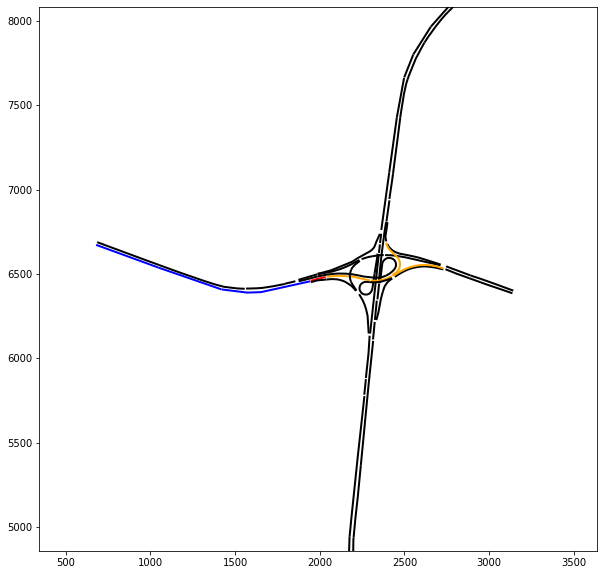

In [388]:
#net_path = '../experiment/Simulations/Base/traci_exp.net.xml'
net_path = '../motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)
plot_options = {'defaultColor': 'black',
                'defaultWidth': 2}
plot_options = dotdict(plot_options)
edge_colors = {incident_edge: 'red'}

for i in range(n_up):
    for id in upstream_edges_ids[i]:
        edge_colors[id] = 'orange'
        
for i in range(n_down):
    for id in downstream_edges_ids[i]:
        edge_colors[id] = 'blue'
        
fig, ax = plt.subplots(1, figsize=(10,10))
plotNet(net, edge_colors, {}, plot_options, i_edge_obj, ax)


## check counterfactuals

In [391]:
results_incident = pd.read_csv(f'{experiment_path}/edgedata.csv', sep=';')
results_incident = results_incident[['edge_id', 'interval_begin', 'edge_density', 'edge_occupancy', 'edge_speed', 'edge_waitingTime', 'edge_timeLoss']]
results_incident_table = results_incident.pivot(index='edge_id', columns='interval_begin', values=['edge_speed','edge_density'])

counterfactual_incident = pd.read_csv(f'{experiment_path}/edgedata_counterfactual.csv', sep=';')
counterfactual_incident = counterfactual_incident[['edge_id', 'interval_begin', 'edge_density', 'edge_occupancy', 'edge_speed', 'edge_waitingTime', 'edge_timeLoss']]
counterfactual_incident_table = counterfactual_incident.pivot(index='edge_id', columns='interval_begin', values=['edge_speed','edge_density'])

relevant_edges = all_upstream_edges_ids + all_downstream_edges_ids + [incident_edge]
upstream_edges = all_upstream_edges_ids + [incident_edge]
downstream_edges = all_downstream_edges_ids + [incident_edge]

In [392]:
results_incident

,edge_id,interval_begin,edge_density,edge_occupancy,edge_speed,edge_waitingTime,edge_timeLoss
0,106130759,44342.0,14.40,1.83,27.56,0.0,7.70
1,106130759-AddedOffRampEdge,44342.0,NaN,NaN,NaN,NaN,NaN
2,106130759.1186,44342.0,1.62,0.20,27.62,0.0,0.37
3,106130759.1630,44342.0,NaN,NaN,NaN,NaN,NaN
4,106130759.1868,44342.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
70555,gneE2,58712.0,60.54,7.41,24.84,0.0,17.34
70556,gneE3,58712.0,55.38,6.88,24.87,0.0,19.61
70557,gneE4,58712.0,47.89,5.96,24.81,0.0,19.76
70558,gneE6,58712.0,41.97,5.16,25.27,0.0,11.37


In [393]:
results_incident_table.iloc[0].loc['edge_speed'].index[1] - results_incident_table.iloc[0].loc['edge_speed'].index[0]

30.0

In [394]:
upstream_edges

['128189136',
 '48290551#1',
 '48290551#0',
 '54121078',
 '621521117',
 '16403446',
 '491989399#0']

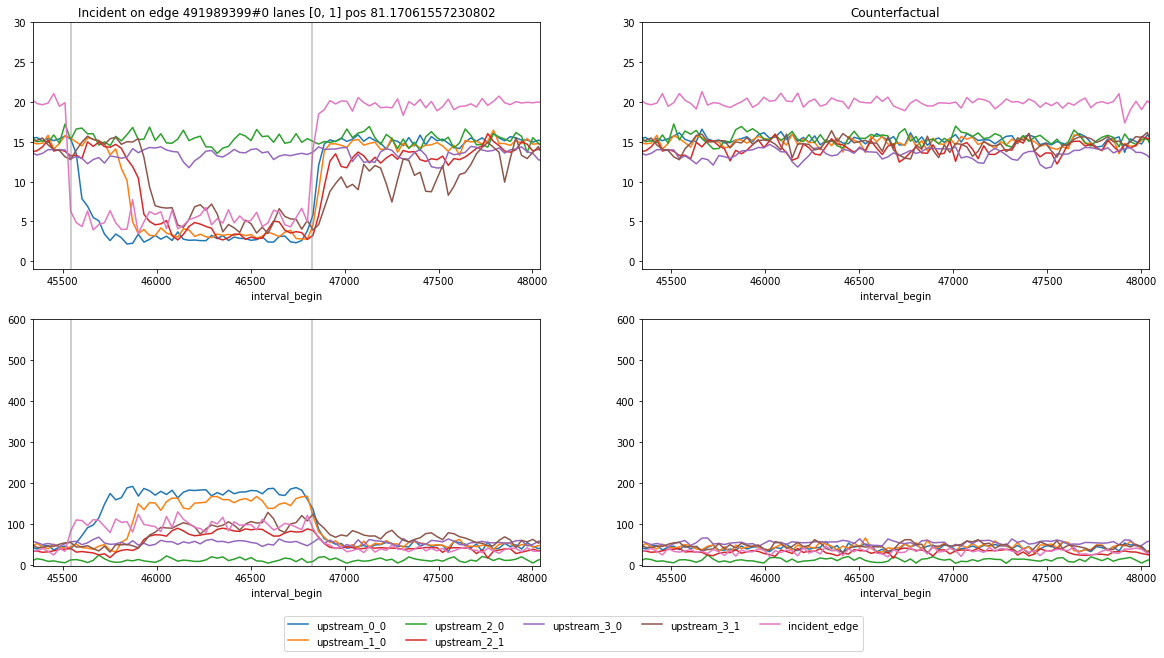

In [397]:
chosen_edges = upstream_edges
#chosen_edges = ['106130759']

fig, ax = plt.subplots(2,2)

results_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,0], legend=False)
ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
results_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,0], legend=False)

counterfactual_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,1], legend=False)
ax[0,1].set_title(f'Counterfactual')
counterfactual_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,1], legend=False)

ax[0,0].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[1,0].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[0,1].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[1,1].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[0,0].set_ylim(-1, 30)
ax[1,0].set_ylim(-1, 600)
ax[0,1].set_ylim(-1, 30)
ax[1,1].set_ylim(-1, 600)


ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)
plt.savefig('fig1.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

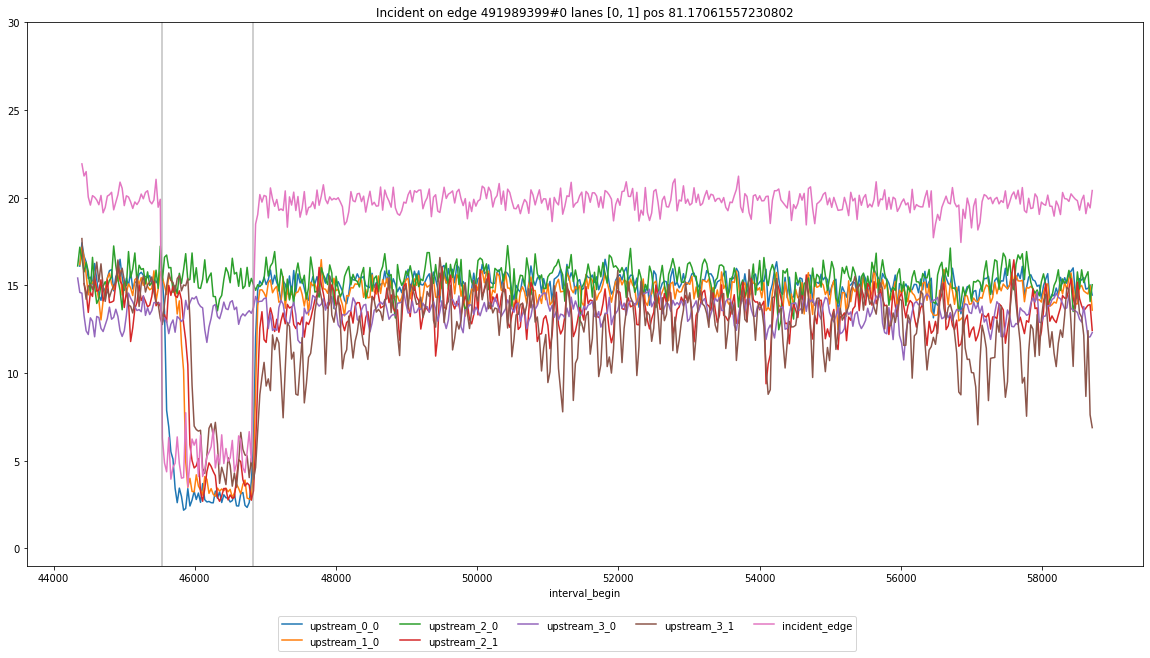

In [398]:
chosen_edges = upstream_edges


fig, ax = plt.subplots(1,1)

results_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax, legend=False)
ax.set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')

#ax.set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax.set_ylim(-1, 30)


ax.axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax.axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)
plt.savefig('fig1.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Attempt at backlog

(45342.0, 48042.0)

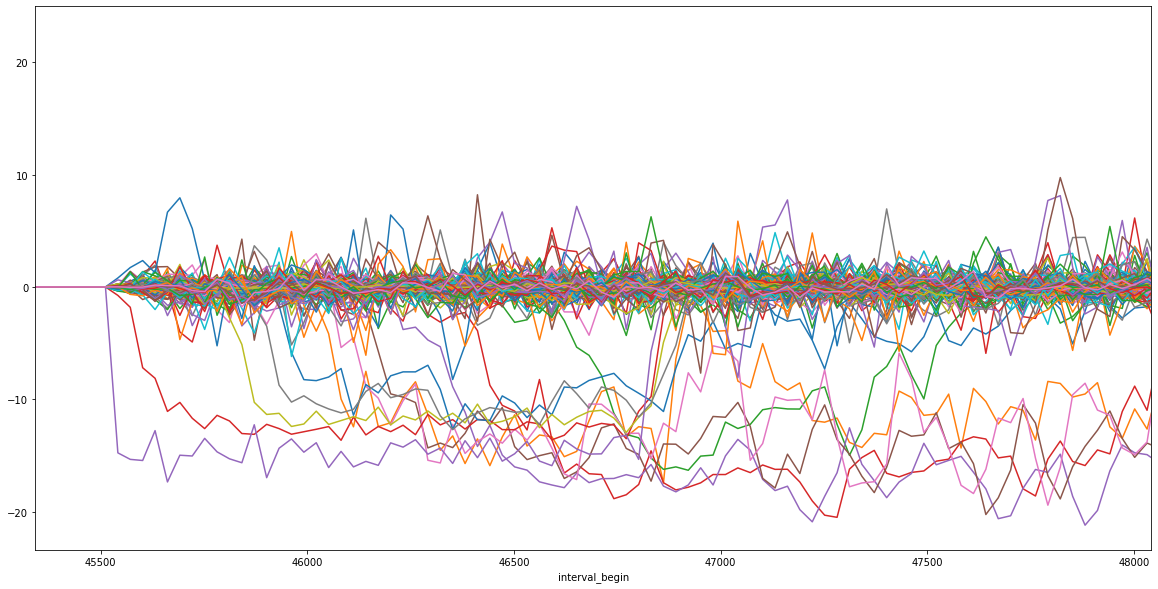

In [403]:
fig, ax = plt.subplots(1)
(results_incident_table.edge_speed - counterfactual_incident_table.edge_speed).T.plot(figsize=(20,10), legend=False, ax=ax)
ax.set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)



In [404]:
edge_colors_2 = {}
for handle in handles:
        edge_colors_2[handle.get_label()] = handle.get_color()

<AxesSubplot:>

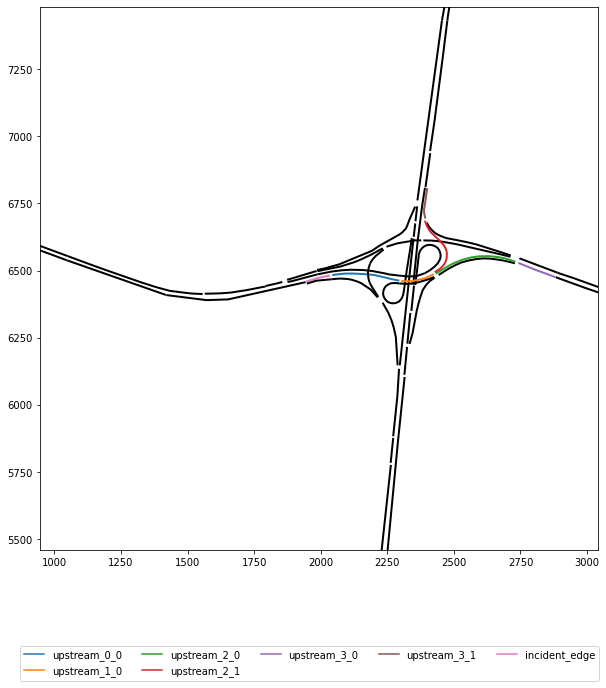

In [405]:
# 3 area = {'xmin':500 , 'xmax':3000 ,'ymin':4000 ,'ymax':8000 }
#area = {'xmin':2000 , 'xmax':2500 ,'ymin':5700 ,'ymax':6800 }
fig, ax = plt.subplots(1, figsize=(10,10))
#plotNet(net, edge_colors_2, {}, plot_options, i_edge_obj, ax, area=area)
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)
plotNet(net, edge_colors_2, {}, plot_options, i_edge_obj, ax, margin=1000)

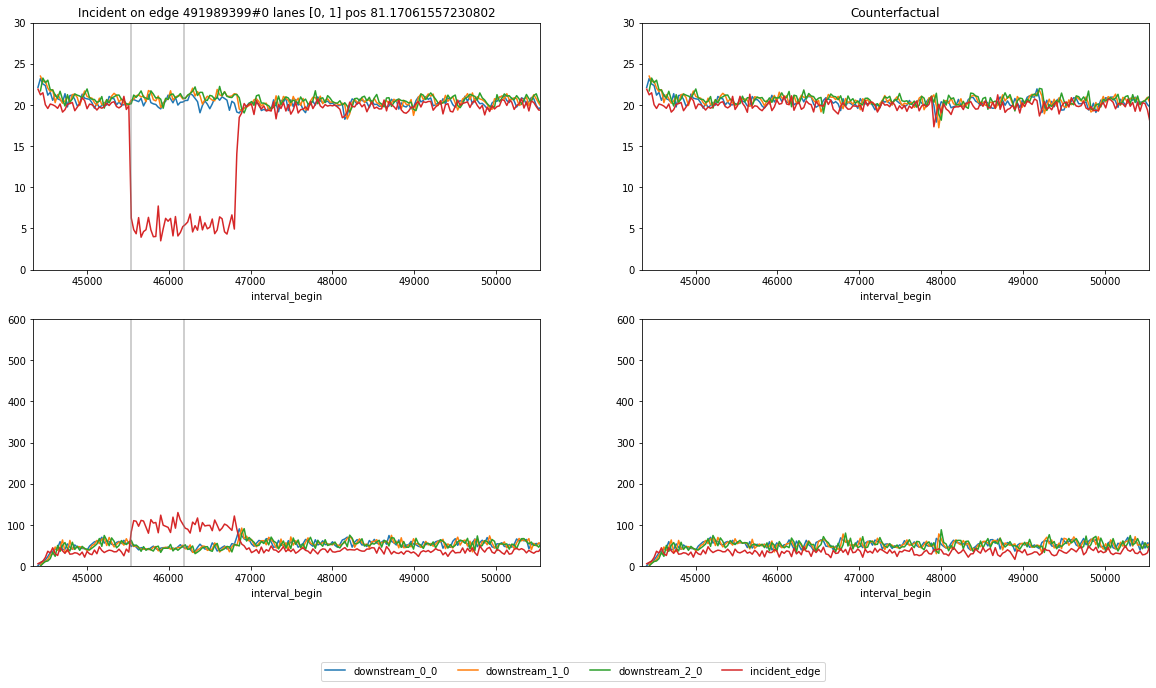

In [406]:
chosen_edges = downstream_edges


fig, ax = plt.subplots(2,2)

results_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,0], legend=False)
ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
results_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,0], legend=False)

counterfactual_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,1], legend=False)
ax[0,1].set_title(f'Counterfactual')
counterfactual_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,1], legend=False)

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 600)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 600)


ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

## Compare edge with detector data

In [407]:
results_detector = pd.read_csv(f'{experiment_path}/detectordata.csv', sep=';')
#results_detector = results_detector.replace(-1,np.nan)
results_detector_table = results_detector.pivot(index='interval_id', columns='interval_begin', values=['interval_flow',
                                                                                                       'interval_harmonicMeanSpeed',
                                                                                                       'interval_nVehContrib',
                                                                                                       'interval_speed'])
#results_detector_table = results_detector_table.groupby(results_detector_table.index.str.split('_').str[1]).mean().T

In [408]:





counterfactual_detector = pd.read_csv(f'{experiment_path}/detectordata_counterfactual.csv', sep=';')
counterfactual_detector = counterfactual_detector.replace(-1,np.nan)



#results_detector_table = results_detector_table.groupby(results_detector_table.index.str.split('_').str[1]).mean().T
#counterfactual_detector_table = counterfactual_detector_table.groupby(counterfactual_detector_table.index.str.split('_').str[1]).mean().T

### Create dataframe structure instead

In [514]:
from data_utils.data_loader_utils import transform_df_to_tensor, get_index_to_edge_dicts

In [515]:
inci_df = pd.read_csv(f'{experiment_path}/detectordata.csv', sep=';')
inci_data = transform_df_to_tensor(inci_df)[:,:,10:,:]

counter_df = pd.read_csv(f'{experiment_path}/detectordata_counterfactual.csv', sep=';')
counter_data = transform_df_to_tensor(counter_df)[:,:,10:,:]

ind_to_edge, edge_to_ind = get_index_to_edge_dicts(inci_df)

In [516]:
# TODO SAVE THIS LANE MASK
lane_mask = ~(inci_data[...,2].mean(-1) == -1)

In [518]:
edge_to_ind[incident_edge]

104

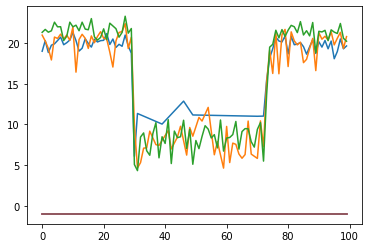

In [519]:
plt.plot(inci_data[104, :, :100, 2].T)

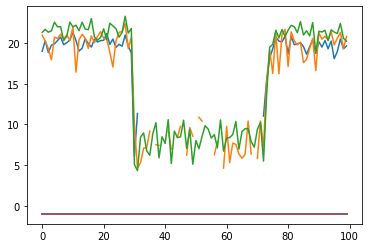

In [520]:
plt.plot(data_raw[104, :, :100, 2].T)

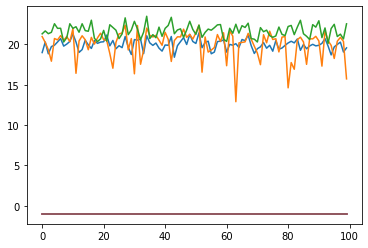

In [521]:
plt.plot(counter_data[104, :, :100, 2].T)

In [430]:
#(counter_data[...,2] - inci_data[...,2]).sum(2)

In [431]:
#np.nanstd(counter_data[...,2], axis = 2)

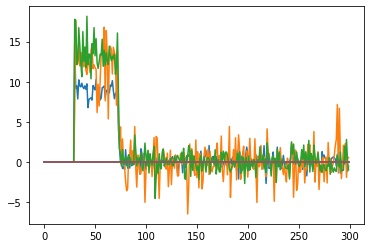

In [526]:
plt.plot(counter_data[104, :, :300, 2].T - data[104, :, :300, 2].T)

In [527]:
counter_data[...,2].std(2)

array([[4.95656524, 5.82485637, 4.62423443, 2.50371711, 0.        ,
        0.        ],
       [2.75913654, 6.32871524, 5.56056437, 5.51963615, 2.209682  ,
        0.        ],
       [5.23399705, 6.73654588, 5.54497842, 3.11517409, 0.        ,
        0.        ],
       [5.25913675, 7.61234481, 5.94184407, 3.36845792, 0.        ,
        0.        ],
       [5.12333113, 8.33514091, 6.26009919, 3.44280225, 0.        ,
        0.        ],
       [4.06574683, 7.67302381, 5.87936307, 3.20059266, 0.        ,
        0.        ],
       [3.5950903 , 7.1095451 , 5.23045622, 2.72117936, 0.        ,
        0.        ],
       [4.94889246, 6.25004631, 5.04681333, 2.57667673, 0.        ,
        0.        ],
       [1.06979476, 0.82025722, 0.87439838, 0.        , 0.        ,
        0.        ],
       [0.9894049 , 1.89012424, 0.62950822, 1.06324699, 0.        ,
        0.        ],
       [0.61319045, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.41758737, 0

In [434]:
chosen_edges = [incident_edge]
chosen_lanes = counterfactual_detector_table.columns.str.split('_').str[1].isin(chosen_edges)



fig, ax = plt.subplots(2,2)

results_detector_table.loc['interval_speed', chosen_lanes].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table.loc['interval_occupancy', chosen_lanes].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table.loc['interval_speed', chosen_lanes].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table.loc['interval_occupancy', chosen_lanes].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')

#ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
#ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
#ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
#ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[0,0].set_ylim(-1, 30)
ax[1,0].set_ylim(-1, 100)
ax[0,1].set_ylim(-1, 30)
ax[1,1].set_ylim(-1, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
#lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)

NameError: name 'counterfactual_detector_table' is not defined

In [ ]:
chosen_edges = upstream_edges

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[0,0].set_ylim(-1, 30)
ax[1,0].set_ylim(-1, 100)
ax[0,1].set_ylim(-1, 30)
ax[1,1].set_ylim(-1, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)

In [ ]:
chosen_edges = downstream_edges

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,0], legend=False)
results_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,0], legend=False)

counterfactual_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,1], legend=False)
counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,1], legend=False)

ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')
ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 100)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 100)
ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

In [ ]:
# Do the mean thing

In [ ]:
results_detector_table.loc['interval_speed']

In [ ]:
chosen_edges = upstream_edges

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table[chosen_edges].loc['interval_occupancy'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_speed'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 100)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

In [ ]:
chosen_edges = upstream_edges
n_mean = 1

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table[chosen_edges].loc['interval_occupancy'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_speed'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 100)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

## Compare incident with counterfactual

- Can we see all of the impacted edges?


In [ ]:
# Seems like I can remove the smalles of them here to find the backlog


In [ ]:
residuals = (results_detector_table.interval_speed - counterfactual_detector_table.interval_speed).T.abs().max()

In [ ]:
residuals.plot()

In [ ]:
results_detector_table.loc[residuals > 5]

In [ ]:
results_detector_table.loc[residuals < 1].interval_speed.T.plot()

In [ ]:
residuals > 1

In [ ]:
plt.plot(residuals)

In [ ]:
with open('incident_settings.json', 'r') as f:
    test = json.load(f)

In [ ]:
test

# Create dataset from simulation

## How to create sequences from simulation

- Do we even do sequence to sequence?
- Do we make multiple sequences from each simulation or is each simulation separate?
- Should the incident happen the same time along the sequence for all of the simulations?
- Should sequences be the same length?
    - If we do backlog then no they should vary in length
    
## Create backlog from comparing incident with counterfactual

- Should it even be created looking at the counterfactual?
- How big a difference is necessary?
    -- Could be based on the LoS from the highway manual
- If this is model output how do we get a model to output it?
    - Some sequence model with a way to determine how to stop
        - This sounds like some NLP like problem